In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import harmonic_distance as hd
import numpy as np
import matplotlib.pyplot as plt
import importlib

In [2]:
c = tf.constant(0.2, dtype=tf.float64)
n_points = 1024

In [3]:
# We're just calculating the unison, fourth, fifth, octave
@tf.function
def get_vectors():
    return hd.vectors.space_graph(2, 3, bounds=(0.0, 1.0))
vecs = get_vectors()
ratios = np.sort(np.prod(hd.PRIMES[:vecs.shape[-1]] ** vecs, axis=1))
# Print out the logs of the vectors
print("Ratios: \t", ratios)
print("Log-2 Ratios: \t", np.log2(ratios))
vecs

W0623 09:51:45.094810 16080 deprecation.py:323] From C:\Users\andrewcsmith\Miniconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Ratios: 	 [1.         1.125      1.33333333 1.5        2.        ]
Log-2 Ratios: 	 [0.        0.169925  0.4150375 0.5849625 1.       ]


<tf.Tensor: id=107, shape=(5, 2), dtype=float64, numpy=
array([[-3.,  2.],
       [-1.,  1.],
       [ 0.,  0.],
       [ 1.,  0.],
       [ 2., -1.]])>

In [4]:
# Tensor for the permutations of unison, fourth, fifth, octave
@tf.function
def get_perms():
    return hd.cartesian.permutations(vecs, times=2)
perms = get_perms()

In [5]:
pds = hd.tenney.pd_aggregate_graph(perms)
hds = hd.tenney.hd_aggregate_graph(perms) + 1.0

In [6]:
log_pitches = tf.Variable(tf.random.uniform([n_points, 2], dtype=tf.float64), name="log_pitches", dtype=tf.float64)
log_pitches

<tf.Variable 'log_pitches:0' shape=(1024, 2) dtype=float64, numpy=
array([[0.45051748, 0.29493469],
       [0.82897355, 0.65372032],
       [0.29920822, 0.15303255],
       ...,
       [0.53547324, 0.73166546],
       [0.52652156, 0.5448573 ],
       [0.96786561, 0.13849204]])>

In [7]:
xs = np.linspace(0.0, 1.0, n_points)

In [8]:
def z_calc(pds, hds, log_pitches, a=1.0, b=1.0):
    """
    pds: Pitch distance coordinate values of each vector in the space
    hds: Aggregate harmonic distance values of each vector in the space
    log_pitches: The set of pitches to evaluate
    """
    distances = tf.map_fn(lambda x: hd.utilities.reduce_parabola(pds - x, curves=(a, b)), log_pitches)
    return tf.reduce_min(distances * hds + hds, axis=1)

In [9]:
def assign_coords_and_return(slice_level, a=1.0, b=1.0):
    """
    Given a y-level (in a 2-dimensional space), take a slice of it with a xs.
    """
    xy_coords = np.hstack([xs[:, None], np.full_like(xs, slice_level)[:, None]])
    
    @tf.function
    def get_z():
        return z_calc(pds, hds, tf.constant(xy_coords, dtype=tf.float64), a=a, b=b)
        
    @tf.function
    def get_pds():
        return pds
    plt.ylim(0.0, 50.0)
    for x in get_pds():
        plt.axvline(x=x[0].numpy())
    plt.plot(xs, get_z())

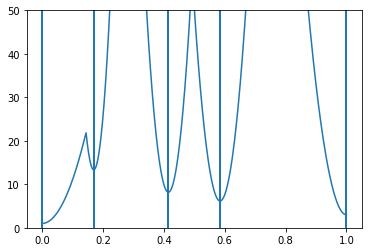

In [10]:
assign_coords_and_return(0.0, a=0.001, b=0.001)

## 2-dimensional optimization

Setting out the batch sizes, etc.

We're reusing the vectors etc. from above

In [11]:
C = 0.02
LEARNING_RATE = 1.0e-3
CONVERGENCE_THRESHOLD = 1.0e-8
MAX_ITERS = 1000000
DIMENSIONS = 2
BATCH_SIZE = 512
POINTS_PER_DIMENSION = 64
xs = np.linspace(0.00, 1.0, POINTS_PER_DIMENSION)
ys = np.linspace(0.00, 1.0, POINTS_PER_DIMENSION)
xv, yv = np.meshgrid(xs, ys, sparse=False)
zv = np.array([])

In [13]:
log_pitches = tf.Variable(tf.random.normal([BATCH_SIZE, DIMENSIONS], dtype=tf.float64))

In [14]:
loss = z_calc(pds, hds, log_pitches, a=C, b=C)

In [21]:
np.save("hds", hds.numpy())
np.save("pds", pds.numpy())

In [15]:
stopping_op = hd.optimize.stopping_op(loss, [log_pitches], lr=LEARNING_RATE, ct=CONVERGENCE_THRESHOLD)

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'GradientDescentOptimizer'

In [60]:
# Creates a vector of pairs of shape [n_points**dimensions, dimensions]
starting_coordinates = np.array([xv, yv]).reshape(DIMENSIONS, POINTS_PER_DIMENSION**DIMENSIONS).T
starting_dataset = tf.data.Dataset.from_tensor_slices({
    "coords": tf.constant(starting_coordinates)
})
starting_iterator = starting_dataset.batch(BATCH_SIZE).make_one_shot_iterator()
next_element = starting_iterator.get_next()
assign_op = log_pitches.assign(next_element['coords'])

In [61]:
all_possible_pitches_log = np.empty([0, 2])

In [62]:
while True:
    try:
        sess.run([assign_op])
        for idx in range(MAX_ITERS):
            if (sess.run(stopping_op)):
                print("Converged at iteration: ", idx)
                out_pitches = np.array(sess.run(log_pitches))
                all_possible_pitches_log = np.concatenate([all_possible_pitches_log, out_pitches])
                break
    except tf.errors.OutOfRangeError:
        break

Converged at iteration:  184
Converged at iteration:  209
Converged at iteration:  216
Converged at iteration:  211
Converged at iteration:  199
Converged at iteration:  207
Converged at iteration:  201
Converged at iteration:  187


In [63]:
all_possible_pitches_log

array([[0.00000000e+00, 0.00000000e+00],
       [1.87200106e-20, 0.00000000e+00],
       [3.74400212e-20, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00]])

In [64]:
print(all_possible_pitches_log.shape)
log_vectors = hd.vectors.pd_graph(vectors)

print(all_possible_pitches_log)
diffs_to_poles = tf.abs(tf.tile(log_vectors[:, None, None], [1, 1, 2]) - all_possible_pitches_log)
mins = tf.argmin(diffs_to_poles, axis=0)
winner = tf.map_fn(lambda m: tf.map_fn(lambda v: vectors[v], m, dtype=tf.float64), mins, dtype=tf.float64)
winners = sess.run(winner)
print(winners)

def vector_to_ratio(vector):
    primes = hd.PRIMES[:vector.shape[0]]
    num = np.where(vector > 0, vector, np.zeros_like(primes))
    den = np.where(vector < 0, vector, np.zeros_like(primes))
    return (
        np.product(np.power(primes, num)), 
        np.product(primes ** np.abs(den))
    )

all_possible_pitches = set()

for row in winners:
    all_possible_pitches.add(tuple([vector_to_ratio(r) for r in row]))

print(len(all_possible_pitches))
print(sorted(all_possible_pitches, key=lambda r: (r[0][0] / r[0][1], r[1][0] / r[1][1])))

(4096, 2)
[[0.00000000e+00 0.00000000e+00]
 [1.87200106e-20 0.00000000e+00]
 [3.74400212e-20 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00]]
[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]]]
20
[((1.0, 1.0), (1.0, 1.0)), ((1.0, 1.0), (5.0, 4.0)), ((1.0, 1.0), (4.0, 3.0)), ((1.0, 1.0), (3.0, 2.0)), ((1.0, 1.0), (5.0, 3.0)), ((1.0, 1.0), (2.0, 1.0)), ((5.0, 4.0), (1.0, 1.0)), ((5.0, 4.0), (5.0, 4.0)), ((4.0, 3.0), (1.0, 1.0)), ((4.0, 3.0), (4.0, 3.0)), ((4.0, 3.0), (2.0, 1.0)), ((3.0, 2.0), (1.0, 1.0)), ((3.0, 2.0), (3.0, 2.0)), ((3.0, 2.0), (2.0, 1.0)), ((5.0, 3.0), (1.0, 1.0)), ((5.0, 3.0), (5.0, 3.0)), ((2.0, 1.0), (1.0, 1.0)), ((2.0, 1.0), (4.0, 3.0)), ((2.0, 1.0), (3.0, 2.0)), ((2.0, 1.0), (2.0, 1.0))]
